In [3]:
# Import necessary libraries
import yfinance as yf
import pandas as pd
import matplotlib.pyplot as plt

# Download stock data (example: Apple - AAPL)
df = yf.download('AAPL', start='2018-01-01', end='2025-01-01')

# Display the first few rows
df.head()


C:\Users\User\AppData\Local\Temp\ipykernel_7708\314847953.py:7: FutureWarning: YF.download() has changed argument auto_adjust default to True
  df = yf.download('AAPL', start='2018-01-01', end='2025-01-01')
[*********************100%***********************]  1 of 1 completed


Price,Close,High,Low,Open,Volume
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL
Date,,,,,
2018-01-02,40.380989,40.390368,39.677733,39.888712,102223600
2018-01-03,40.373966,40.917820,40.310676,40.444293,118071600
2018-01-04,40.561497,40.664642,40.338800,40.446630,89738400
2018-01-05,41.023308,41.110042,40.566192,40.657615,94640000
2018-01-08,40.870934,41.166300,40.772474,40.870934,82271200


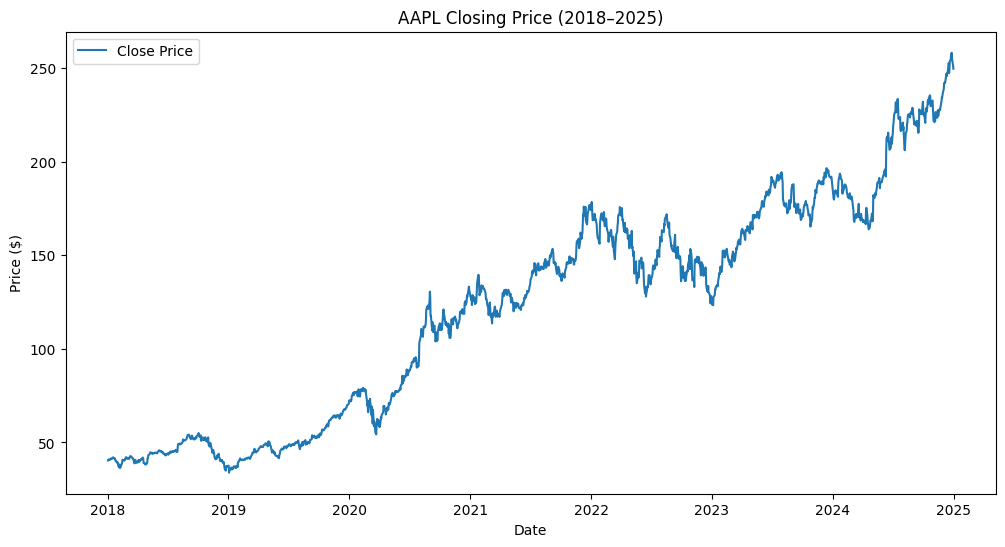

In [4]:
# Plot the closing price over time
plt.figure(figsize=(12,6))
plt.plot(df['Close'], label='Close Price')
plt.title('AAPL Closing Price (2018–2025)')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [5]:
# Moving Averages
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# RSI Calculation
delta = df['Close'].diff()
gain = delta.where(delta > 0, 0)
loss = -delta.where(delta < 0, 0)
avg_gain = gain.rolling(window=14).mean()
avg_loss = loss.rolling(window=14).mean()
rs = avg_gain / avg_loss
df['RSI'] = 100 - (100 / (1 + rs))

# Drop rows with NaN values (first 50 rows will have NaN due to MA50)
df = df.dropna()

# Show the updated dataframe
df.head()


Price,Close,High,Low,Open,Volume,MA20,MA50,RSI
Ticker,AAPL,AAPL,AAPL,AAPL,AAPL,,,
Date,,,,,,,,
2018-03-14,42.000244,42.489824,41.851957,42.442750,117473600,41.378506,40.471651,62.364642
2018-03-15,42.049679,42.423927,41.913165,42.014374,90975200,41.511258,40.505024,57.418748
2018-03-16,41.901390,42.160300,41.807238,42.049674,157618800,41.570455,40.535573,47.417128
2018-03-19,41.261177,41.771940,40.875163,41.736635,133787200,41.604231,40.549566,42.474476
2018-03-20,41.247051,41.614235,41.176438,41.247051,78597600,41.644128,40.554041,42.913486


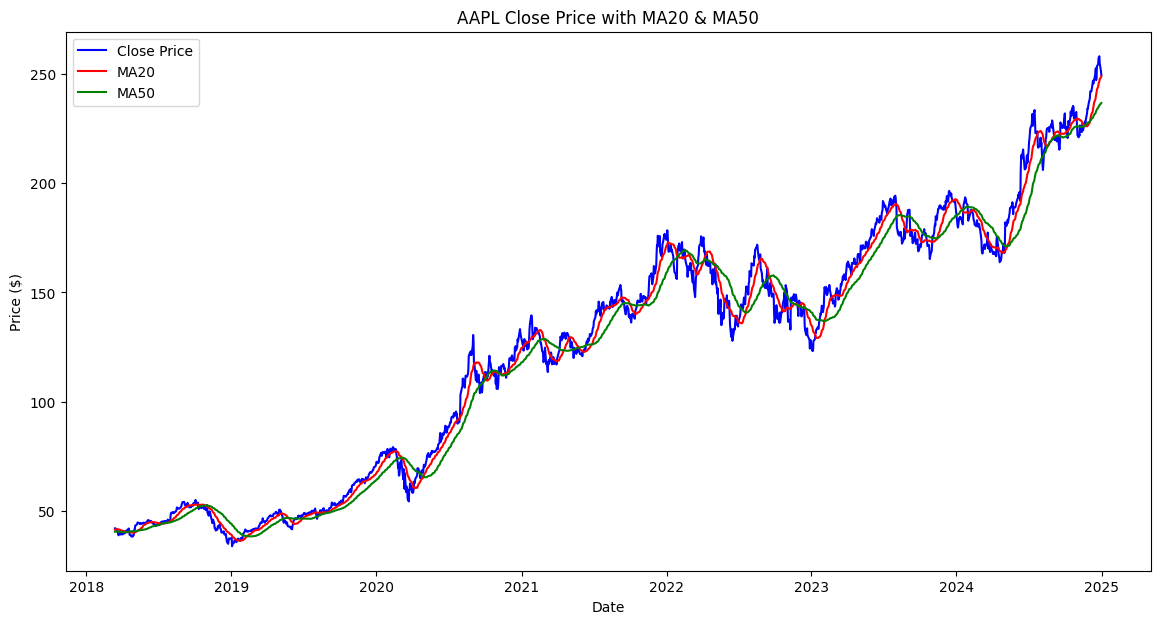

In [6]:
plt.figure(figsize=(14,7))
plt.plot(df['Close'], label='Close Price', color='blue')
plt.plot(df['MA20'], label='MA20', color='red')
plt.plot(df['MA50'], label='MA50', color='green')
plt.title('AAPL Close Price with MA20 & MA50')
plt.xlabel('Date')
plt.ylabel('Price ($)')
plt.legend()
plt.show()


In [7]:
from sklearn.preprocessing import MinMaxScaler
import numpy as np

# Select features
features = ['Close', 'MA20', 'MA50', 'RSI']
data = df[features].values

# Normalize data
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Function to create sequences
def create_sequences(data, seq_length=60):
    X = []
    y = []
    for i in range(seq_length, len(data)):
        X.append(data[i-seq_length:i])
        y.append(data[i, 0])  # Predict 'Close' price
    return np.array(X), np.array(y)

seq_length = 60
X, y = create_sequences(scaled_data, seq_length)

# Split into training and testing (80% train, 20% test)
split = int(0.8 * len(X))
X_train, X_test = X[:split], X[split:]
y_train, y_test = y[:split], y[split:]

# Check shapes
print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)
print("X_test shape:", X_test.shape)
print("y_test shape:", y_test.shape)


X_train shape: (1321, 60, 4)
y_train shape: (1321,)
X_test shape: (331, 60, 4)
y_test shape: (331,)


In [9]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense, Dropout

# Build LSTM model
model = Sequential([
    LSTM(64, return_sequences=True, input_shape=(X_train.shape[1], X_train.shape[2])),
    Dropout(0.2),
    LSTM(64, return_sequences=False),
    Dropout(0.2),
    Dense(32, activation='relu'),
    Dense(1)  # Predicting closing price
])

model.compile(optimizer='adam', loss='mean_squared_error')
model.summary()


Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ lstm_2 (LSTM)                        │ (None, 60, 64)              │          17,664 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 60, 64)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_3 (LSTM)                        │ (None, 64)                  │          33,024 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 64)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 32)                  │           2,080 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              33 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 52,801 (206.25 KB)

 Trainable params: 52,801 (206.25 KB)

 Non-trainable params: 0 (0.00 B)

In [10]:
history = model.fit(
    X_train, y_train,
    epochs=50,
    batch_size=32,
    validation_data=(X_test, y_test)
)


Epoch 1/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 16s 122ms/step - loss: 0.0118 - val_loss: 0.0142
Epoch 2/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 94ms/step - loss: 0.0021 - val_loss: 0.0054
Epoch 3/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 86ms/step - loss: 0.0018 - val_loss: 0.0035
Epoch 4/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0015 - val_loss: 0.0069
Epoch 5/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 92ms/step - loss: 0.0014 - val_loss: 0.0012
Epoch 6/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - loss: 0.0015 - val_loss: 0.0032
Epoch 7/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0011 - val_loss: 0.0026
Epoch 8/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 4s 83ms/step - loss: 0.0011 - val_loss: 0.0078
Epoch 9/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 80ms/step - loss: 9.9066e-04 - val_loss: 0.0058
Epoch 10/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 6s 91ms/step - loss: 0.0012 - val_loss: 0.0090
Epoch 11/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 89ms/step - loss: 0.0011 - val_loss: 0.0023
Epoch 12/50
42/42 ━━━━━━━━━━━━━━━━━━━━ 5s 83ms/step - los

In [11]:
from sklearn.metrics import mean_squared_error, mean_absolute_error

# Make predictions
y_pred = model.predict(X_test)

# Inverse scale if you normalized
# y_pred = scaler.inverse_transform(...)

# Compute metrics
mse = mean_squared_error(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)
print(f"Mean Squared Error: {mse}")
print(f"Mean Absolute Error: {mae}")


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 132ms/step
Mean Squared Error: 0.009098184564084231
Mean Absolute Error: 0.09039938809417589


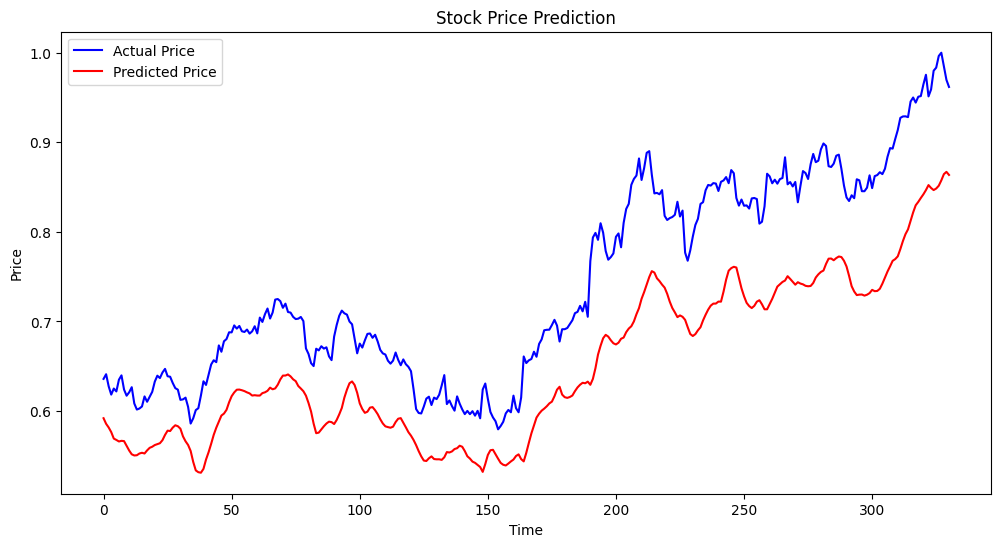

In [12]:
plt.figure(figsize=(12,6))
plt.plot(y_test, color='blue', label='Actual Price')
plt.plot(y_pred, color='red', label='Predicted Price')
plt.title('Stock Price Prediction')
plt.xlabel('Time')
plt.ylabel('Price')
plt.legend()
plt.show()


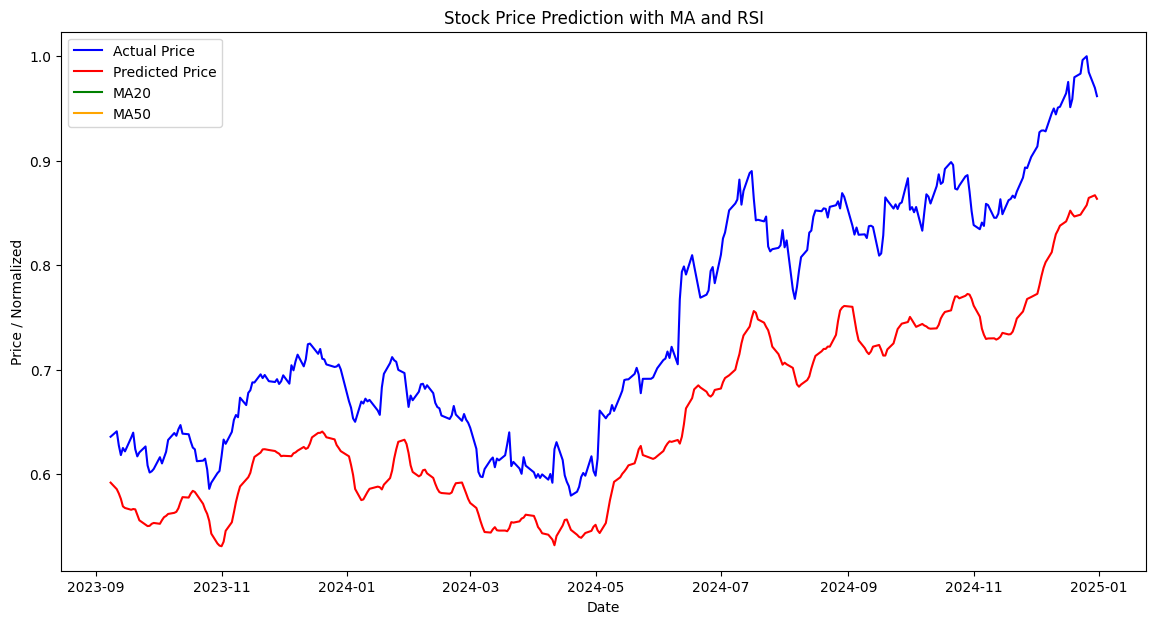

In [13]:
import pandas as pd
import matplotlib.pyplot as plt

# Assuming 'df' contains your original stock data
# And 'Close' is the closing price column

# Moving Averages
df['MA20'] = df['Close'].rolling(window=20).mean()
df['MA50'] = df['Close'].rolling(window=50).mean()

# Relative Strength Index (RSI)
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(window=14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(window=14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))

# Plot Predictions + Indicators
plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], y_test, color='blue', label='Actual Price')
plt.plot(df.index[-len(y_test):], y_pred, color='red', label='Predicted Price')
plt.plot(df.index[-len(df['MA20']):], df['MA20'][-len(df['MA20']):], color='green', label='MA20')
plt.plot(df.index[-len(df['MA50']):], df['MA50'][-len(df['MA50']):], color='orange', label='MA50')
plt.title('Stock Price Prediction with MA and RSI')
plt.xlabel('Date')
plt.ylabel('Price / Normalized')
plt.legend()
plt.show()


In [14]:
# Save the entire model (architecture + weights + optimizer)
model.save("lstm_stock_model.h5")


In [15]:
from tensorflow.keras.models import load_model

# Load the saved model
loaded_model = load_model("lstm_stock_model.h5")

# Check if it works by making predictions
y_pred_loaded = loaded_model.predict(X_test)


11/11 ━━━━━━━━━━━━━━━━━━━━ 2s 118ms/step


In [16]:
# Moving Averages
df['MA20'] = df['Close'].rolling(window=20).mean()  # 20-day simple MA
df['EMA20'] = df['Close'].ewm(span=20, adjust=False).mean()  # 20-day exponential MA

# RSI
delta = df['Close'].diff()
gain = (delta.where(delta > 0, 0)).rolling(14).mean()
loss = (-delta.where(delta < 0, 0)).rolling(14).mean()
rs = gain / loss
df['RSI'] = 100 - (100 / (1 + rs))


In [19]:
!pip install ta

import ta

# Option 1: Use .squeeze() to make it 1D
df['EMA20'] = ta.trend.EMAIndicator(df['Close'].squeeze(), window=20).ema_indicator()
df['EMA50'] = ta.trend.EMAIndicator(df['Close'].squeeze(), window=50).ema_indicator()
df['RSI'] = ta.momentum.RSIIndicator(df['Close'].squeeze(), window=14).rsi()



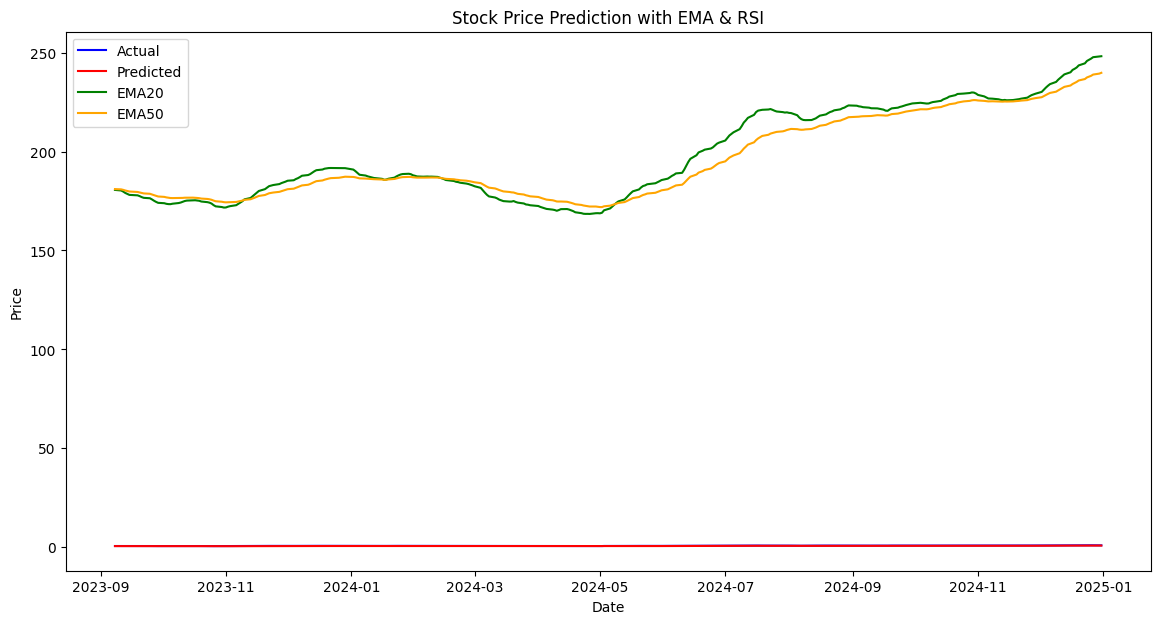

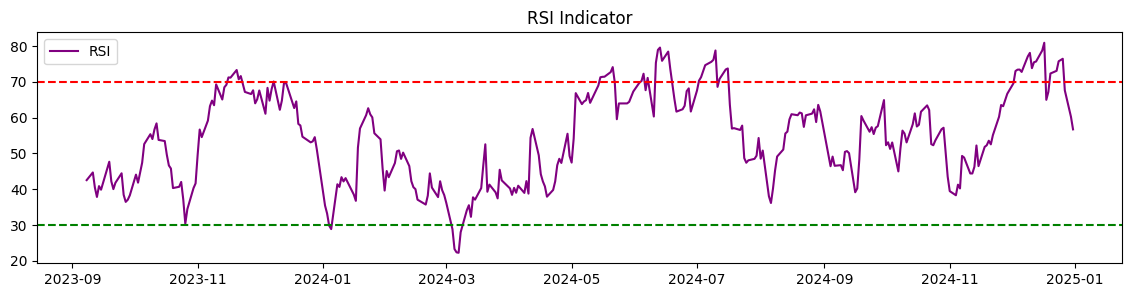

In [20]:
import matplotlib.pyplot as plt

plt.figure(figsize=(14,7))
plt.plot(df.index[-len(y_test):], y_test, label='Actual', color='blue')
plt.plot(df.index[-len(y_test):], y_pred, label='Predicted', color='red')
plt.plot(df.index[-len(y_test):], df['EMA20'][-len(y_test):], label='EMA20', color='green')
plt.plot(df.index[-len(y_test):], df['EMA50'][-len(y_test):], label='EMA50', color='orange')
plt.title('Stock Price Prediction with EMA & RSI')
plt.xlabel('Date')
plt.ylabel('Price')
plt.legend()
plt.show()

# RSI separately
plt.figure(figsize=(14,3))
plt.plot(df.index[-len(y_test):], df['RSI'][-len(y_test):], label='RSI', color='purple')
plt.axhline(70, color='red', linestyle='--')  # Overbought
plt.axhline(30, color='green', linestyle='--')  # Oversold
plt.title('RSI Indicator')
plt.legend()
plt.show()
